In [54]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
import zipfile
import io

In [56]:
with zipfile.ZipFile('/content/positive.zip', 'r') as zip_ref:
    zip_ref.extractall('POS_PATH')

In [57]:
with zipfile.ZipFile('/content/anchor.zip', 'r') as zip_ref:
    zip_ref.extractall('ANC_PATH')

In [58]:
with zipfile.ZipFile('/content/negative.zip', 'r') as zip_ref:
    zip_ref.extractall('NEG_PATH')

In [59]:
ANC_PATH = '/content/ANC_PATH/anchor'
POS_PATH = '/content/POS_PATH/positive'
NEG_PATH = '/content/NEG_PATH/negative'

anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [60]:
dir_test = anchor.as_numpy_iterator()

In [61]:
print(dir_test.next())

b'/content/ANC_PATH/anchor/2d7f1d19-3cd5-11ee-9eb1-3003c8e2f0f6.jpg'


In [62]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 105x105x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [63]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) #creating a positive dataset by zipping together three components: anchor, positive, and a dataset created from a tensor of ones. The tensor of ones is used to label the positive examples.
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [64]:
samples = data.as_numpy_iterator() # It creates an iterator named samples that allows you to iterate over the elements of the TensorFlow Dataset named data and obtain them as NumPy arrays.
# for sample in samples:
#     anchor_image = sample[0]  # NumPy array of anchor image
#     positive_image = sample[1]  # NumPy array of positive image
#     label = sample[2]  # Label (0 for negative, 1 for positive) as a NumPy array

#     # Now you can work with anchor_image, positive_image, and label as NumPy arrays
#     # For example, you can perform image processing or analysis using common NumPy functions


In [65]:
example = samples.next()
example

(b'/content/ANC_PATH/anchor/cc5a7700-3cd5-11ee-a6e6-3003c8e2f0f6.jpg',
 b'/content/POS_PATH/positive/094f42f6-3cdc-11ee-bf0a-3003c8e2f0f6.jpg',
 1.0)

In [66]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [67]:
res = preprocess_twin(*example)

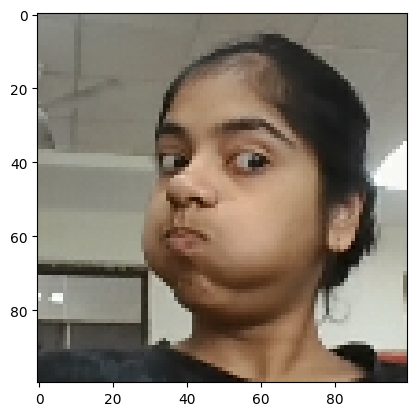

In [68]:
plt.imshow(res[1])

In [69]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()   #caching the elements of the dataset in memory or on disk. This can help improve training performance by avoiding redundant loading and preprocessing of the data during training. Cached data is stored in memory (if possible) for faster access.
data = data.shuffle(buffer_size=10000)  # shuffling the elements of the dataset randomly. The shuffle function shuffles the elements using a buffer of the specified size (in this case, 1000)

In [70]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [71]:
# Testing partition
test_data = data.skip(round(len(data)*.7)) # skipping the first portion of the dataset, which corresponds to approximately 70% of the data
test_data = test_data.take(round(len(data)*.3)) # After skipping the initial portion, you are then taking a subset of the data, which corresponds to approximately 30% of the original dataset.
test_data = test_data.batch(8)  #batching the testing data into batches of size 8
test_data = test_data.prefetch(4) # prefetching data to make sure the next batch of data is loaded in the background while the current batch is being processed. A buffer size of 4 indicates how many batches should be prefetched.

In [72]:
from tensorflow.keras.layers import Dropout
def Siamese():
  inp = Input(shape=(100,100,3), name='Input_Layer')
  conv1 = Conv2D(64, (10,10), activation='relu')(inp) #The line defines a convolutional layer c1 with 64 filters of size 10x10, using the ReLU activation function, applied to the input tensor inp.
  m1 = MaxPooling2D(pool_size= (2,2), padding='same')(conv1) #It performs max-pooling with a 2x2 window size and 'same' padding on the output of a convolutional layer conv1.
  conv2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(pool_size= (2,2), padding='same')(conv2)
  conv2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(pool_size= (2,2), padding='same')(conv2)
  conv2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(pool_size= (2,2), padding='same')(conv2)
  conv3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(pool_size= (2,2), padding='same')(conv3)
  conv4 = Conv2D(256, (4,4), activation='relu')(m3)
  d1 = Dropout(rate=0.5)(conv4)
  f1 = Flatten()(d1)  #Flattening after convolutional and pooling layers transforms spatially organized feature maps into a 1D vector, enabling fully connected layers to utilize learned features for decision-making in CNNs.
  d1 = Dense(4096, activation='sigmoid')(f1)  # fully connected layer with 4096 neurons and sigmoid activation function is applied to the input f1.
  return Model(inputs=[inp], outputs=[d1], name='SNN')


In [73]:
SNN = Siamese()
SNN.summary()

Model: "SNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 17, 17, 128)       262272  

In [74]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

#The L1Dist custom layer calculates the L1 distance (Manhattan distance) between two input embeddings. It is intended to be used as a layer within a neural network model. When you pass two embeddings (input_embedding and validation_embedding) to the layer's call method, it computes the absolute difference between the embeddings element-wise, resulting in the L1 distance between the two embeddings. This kind of custom layer can be useful for tasks like computing distances or similarities between pairs of data points in a Siamese network or other similar architectures.

In [75]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(SNN(input_image), SNN(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [76]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 SNN (Functional)               (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [77]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001) # 0.0001

In [78]:
siamese_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [80]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [81]:
test_batch = train_data.as_numpy_iterator()

In [82]:
batch_1 = test_batch.next()

In [83]:
X = batch_1[:2]

In [84]:
y = batch_1[2]

In [85]:
y

array([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [86]:
@tf.function   #technique to create a tensorflow graph for faster execution.
def train_step(batch): #takes a batch of data as input and represents a single training step.

    # Record all of our operations
    with tf.GradientTape() as tape: # a context manager in TensorFlow that records operations inside it to compute gradients for automatic differentiation, crucial for optimizing machine learning models.
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True) #Passes the input images X through the siamese model to get predicted similarity scores yhat
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [87]:
def train(data, EPOCHS, patience=5):
    best_recall = 0.0  # Initialize with the worst value (0.0 for recall)
    best_precision = 0.0  # Initialize with the worst value (0.0 for precision)
    consecutive_no_improvement = 0

    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Get the current recall and precision values
        current_recall = r.result().numpy()
        current_precision = p.result().numpy()

        # Check for early stopping based on recall
        if current_recall > best_recall:
            best_recall = current_recall
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        # Check for early stopping based on precision
        if current_precision > best_precision:
            best_precision = current_precision
            consecutive_no_improvement = 0

        # Early stopping based on both metrics
        if consecutive_no_improvement >= patience:
            print(f"Early stopping: No improvement for {patience} epochs.")
            break

In [88]:
EPOCHS = 50

In [89]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 176s 6s/step
0.6992232 0.18274112 0.7346939

 Epoch 2/50
27/27 [==============================] - 175s 6s/step
0.69842273 0.2112676 0.9183673

 Epoch 3/50
27/27 [==============================] - 174s 6s/step
0.5462915 0.44878048 0.8679245

 Epoch 4/50
27/27 [==============================] - 175s 7s/step
0.32256785 0.7718447 0.86885244

 Epoch 5/50
27/27 [==============================] - 175s 7s/step
0.37679625 0.90865386 0.9264706

 Epoch 6/50
27/27 [==============================] - 181s 7s/step
0.1650649 0.92727274 0.9230769

 Epoch 7/50
27/27 [==============================] - 174s 6s/step
0.109158404 0.96153843 0.9478673

 Epoch 8/50
27/27 [==============================] - 176s 7s/step
0.00861805 0.980198 0.96585363

 Epoch 9/50
27/27 [==============================] - 181s

In [90]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [91]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 588ms/step


In [92]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 1, 1]

In [93]:
y_true

array([0., 1., 0., 1., 0., 1., 1., 1.], dtype=float32)

In [94]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [95]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [96]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 337ms/step
1.0 1.0


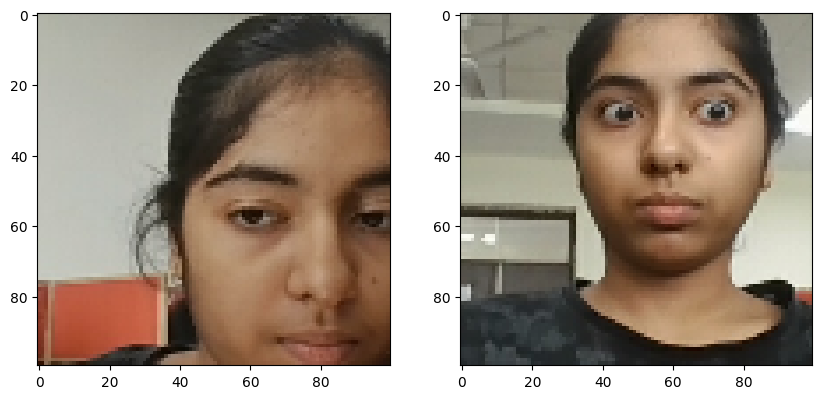

In [97]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [98]:
# Save weights
siamese_model.save('verification.h5')

In [99]:
# Reload model
siamese_model = tf.keras.models.load_model('verification.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [100]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 470ms/step


array([[0.01117764],
       [0.9516728 ],
       [0.16181844],
       [0.99994594]], dtype=float32)